# 0. Import libraries and load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import sys

In [2]:
# Classification models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, auc

## Paths

In [3]:
# Check whether the code is running in Google Colab or in a local environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Mount Google Drive to access datasets
  from google.colab import drive, userdata
  gdrive_string = '/content/drive'
  drive.mount(gdrive_string)

  dataset_path = f'{gdrive_string}/MyDrive/BPI DATA Wave 2025/Potential Datasets'
  employee_df = pd.read_csv(f'{dataset_path}/banking_employee_data.csv')
else:
  # Local environment setup
  dataset_path = '../Datasets'
  employee_df = pd.read_csv(f'{dataset_path}/banking_employee_data.csv')

In [4]:
employee_df.head()

,Department,Gender,Job_Title,Employee_ID,Age,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,...,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned,Resignation_Date,Hiring_Age
0,Retail Banking,Male,Branch Manager,1,60,1988-01-01,37.60,Bachelor,3.22,149436,...,0,5,4,2,19,4,3.11,False,NaN,22
1,Retail Banking,Female,Branch Manager,2,60,1988-01-01,37.60,Bachelor,3.70,220296,...,3,2,3,8,41,4,4.07,False,NaN,22
2,Compliance,Male,Compliance Officer,3,60,1988-01-02,37.60,Bachelor,3.62,161636,...,0,5,2,6,10,3,3.19,False,NaN,22
3,Risk Management,Male,Risk Manager,4,60,1988-01-04,37.59,Master,3.28,228415,...,13,6,3,3,32,2,2.59,False,NaN,22
4,Compliance,Female,Compliance Officer,5,60,1988-01-04,37.59,Bachelor,3.31,165926,...,13,6,4,21,16,2,3.18,False,NaN,22


In [5]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Department                   100000 non-null  object 
 1   Gender                       100000 non-null  object 
 2   Job_Title                    100000 non-null  object 
 3   Employee_ID                  100000 non-null  int64  
 4   Age                          100000 non-null  int64  
 5   Hire_Date                    100000 non-null  object 
 6   Years_At_Company             100000 non-null  float64
 7   Education_Level              100000 non-null  object 
 8   Performance_Score            100000 non-null  float64
 9   Monthly_Salary               100000 non-null  int64  
 10  Work_Hours_Per_Week          100000 non-null  int64  
 11  Projects_Handled             100000 non-null  int64  
 12  Overtime_Hours               100000 non-null  int64  
 13  

# 1. Modeling

In [6]:
# Set target
target = "Resigned"
cols_to_drop = ["Employee_ID", "Hire_Date", "Resignation_Date", "Hiring_Age", target]

X = employee_df.drop(columns=cols_to_drop)
y = employee_df[target].astype('int')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
X.columns

Index(['Department', 'Gender', 'Job_Title', 'Age', 'Years_At_Company',
       'Education_Level', 'Performance_Score', 'Monthly_Salary',
       'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours',
       'Sick_Days', 'Remote_Work_Frequency', 'Team_Size', 'Training_Hours',
       'Promotions', 'Employee_Satisfaction_Score'],
      dtype='object')

In [8]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(num_cols)
print(cat_cols)

['Age', 'Years_At_Company', 'Performance_Score', 'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled', 'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size', 'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score']
['Department', 'Gender', 'Job_Title', 'Education_Level']


In [9]:
# Create a preprocessor
preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
  ],
  remainder='passthrough'
)

## XGBoost

In [10]:
# Create a pipeline for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='aucpr', scale_pos_weight=scale_pos_weight))
])

pipe_xgb.fit(X_train, y_train)

y_pred_xgb = pipe_xgb.predict(X_test)
y_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

print("Metrics of XGBoost:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb)}')
print(f'PR AUC: {auc(recall_xgb, precision_xgb)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb)}')

Metrics of XGBoost:
Accuracy: 0.83645
ROC AUC: 0.9270981953705321
PR AUC: 0.8028099714118425
Training Accuracy: 0.864225

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89     15417
           1       0.60      0.86      0.71      4583

    accuracy                           0.84     20000
   macro avg       0.78      0.84      0.80     20000
weighted avg       0.87      0.84      0.85     20000

Confusion Matrix:
 [[12793  2624]
 [  647  3936]]


## Logistic Regression

In [11]:
pipe_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipe_logreg.fit(X_train, y_train)

y_pred_logreg = pipe_logreg.predict(X_test)
y_prob_logreg = pipe_logreg.predict_proba(X_test)[:, 1]

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_prob_logreg)

print("Metrics of Logistic Regression:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_logreg)}')
print(f'PR AUC: {auc(recall_logreg, precision_logreg)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_logreg.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_logreg)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_logreg)}')

Metrics of Logistic Regression:
Accuracy: 0.84145
ROC AUC: 0.8795857728427766
PR AUC: 0.7016169435505395
Training Accuracy: 0.8396

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     15417
           1       0.71      0.53      0.60      4583

    accuracy                           0.84     20000
   macro avg       0.79      0.73      0.75     20000
weighted avg       0.83      0.84      0.83     20000

Confusion Matrix:
 [[14419   998]
 [ 2173  2410]]


# 2. Hyperparameter Tuning

## RandomSearchCV

In [12]:
# Parameter tuning for XGBoost
xgb_tuned = XGBClassifier(
  eval_metric='aucpr',
  scale_pos_weight=scale_pos_weight
)

# Define parameter grid
param_grid = {
  'n_estimators': [500, 600, 700, 800, 900, 1000],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.05, 0.1, 0.2, 0.3]
}

# Perform random search
random_search = RandomizedSearchCV(xgb_tuned, param_grid, n_iter=10, cv=10, scoring='f1', n_jobs=-1, random_state=42)
random_precision = RandomizedSearchCV(xgb_tuned, param_grid, n_iter=10, cv=10, scoring='precision', n_jobs=-1, random_state=42)
random_recall = RandomizedSearchCV(xgb_tuned, param_grid, n_iter=10, cv=10, scoring='recall', n_jobs=-1, random_state=42)

### F1 score-focused

In [13]:
# Create a pipeline for XGBoost RandomSearchCV (F1)
pipe_xgb_random = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('random_search', random_search)
])

pipe_xgb_random.fit(X_train, y_train)

y_pred_xgb_random = pipe_xgb_random.predict(X_test)
y_prob_xgb_random = pipe_xgb_random.predict_proba(X_test)[:,1]

precision_xgb_random, recall_xgb_random, _ = precision_recall_curve(y_test, y_prob_xgb_random)

best_params_xgb_f1 = pipe_xgb_random.named_steps["random_search"].best_params_

print("XGBoost Random Search Model (F1 focus)")
print(f'Best Parameters: {best_params_xgb_f1}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb_random)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb_random)}')
print(f'PR AUC: {auc(recall_xgb_random, precision_xgb_random)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb_random.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_random)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_random)}')

XGBoost Random Search Model (F1 focus)
Best Parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05}
Accuracy: 0.83755
ROC AUC: 0.9292977644920197
PR AUC: 0.8089716058570561
Training Accuracy: 0.872275

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89     15417
           1       0.60      0.86      0.71      4583

    accuracy                           0.84     20000
   macro avg       0.78      0.85      0.80     20000
weighted avg       0.87      0.84      0.85     20000

Confusion Matrix:
 [[12812  2605]
 [  644  3939]]


### Precision-focused

In [14]:
# Create a pipeline for XGBoost RandomSearchCV (Precision)
pipe_xgb_random = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('random_search', random_precision)
])

pipe_xgb_random.fit(X_train, y_train)

y_pred_xgb_random = pipe_xgb_random.predict(X_test)
y_prob_xgb_random = pipe_xgb_random.predict_proba(X_test)[:,1]

precision_xgb_random, recall_xgb_random, _ = precision_recall_curve(y_test, y_prob_xgb_random)

best_params_xgb_precision = pipe_xgb_random.named_steps["random_search"].best_params_

print("XGBoost Random Search Model (Precision focus)")
print(f'Best Parameters: {best_params_xgb_precision}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb_random)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb_random)}')
print(f'PR AUC: {auc(recall_xgb_random, precision_xgb_random)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb_random.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_random)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_random)}')

XGBoost Random Search Model (Precision focus)
Best Parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.2}
Accuracy: 0.8547
ROC AUC: 0.9216943528069355
PR AUC: 0.7907475550479179
Training Accuracy: 0.9815375

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90     15417
           1       0.66      0.76      0.71      4583

    accuracy                           0.85     20000
   macro avg       0.79      0.82      0.80     20000
weighted avg       0.86      0.85      0.86     20000

Confusion Matrix:
 [[13619  1798]
 [ 1108  3475]]


### Recall-focused

In [15]:
# Create a pipeline for XGBoost RandomSearchCV (Recall)
pipe_xgb_random = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('random_search', random_recall)
])

pipe_xgb_random.fit(X_train, y_train)

y_pred_xgb_random = pipe_xgb_random.predict(X_test)
y_prob_xgb_random = pipe_xgb_random.predict_proba(X_test)[:,1]

precision_xgb_random, recall_xgb_random, _ = precision_recall_curve(y_test, y_prob_xgb_random)

best_params_xgb_recall = pipe_xgb_random.named_steps["random_search"].best_params_

print("XGBoost Random Search Model (Recall focus)")
print(f'Best Parameters: {best_params_xgb_recall}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb_random)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb_random)}')
print(f'PR AUC: {auc(recall_xgb_random, precision_xgb_random)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb_random.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_random)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_random)}')

XGBoost Random Search Model (Recall focus)
Best Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05}
Accuracy: 0.82615
ROC AUC: 0.9263191473983051
PR AUC: 0.7937271666985356
Training Accuracy: 0.8308625

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     15417
           1       0.58      0.88      0.70      4583

    accuracy                           0.83     20000
   macro avg       0.77      0.84      0.79     20000
weighted avg       0.87      0.83      0.84     20000

Confusion Matrix:
 [[12500  2917]
 [  560  4023]]


*The recall-focused model catches the highest amount of true positives (employees who resigned) and the lowest false negatives (uncatched employees who resigned), which is the primary task of this model, to detect preventable attrition. However, this comes with the lowest precision and high number of false positives (false alarms).*

## Apply GridSearchCV around the best parameters

In [16]:
# Parameter tuning for XGBoost
xgb_tuned = XGBClassifier(
  eval_metric='aucpr',
  scale_pos_weight=scale_pos_weight
)

# Define parameter grid
param_grid = {
  'n_estimators': [1000, 1500],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.01, 0.05, 0.1]
}

xgb_grid_recall = GridSearchCV(xgb_tuned, param_grid, cv=10, scoring='recall', n_jobs=-1)

In [17]:
# Create a pipeline for Grid XGBoost
pipe_xgb_grid = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('classifier', xgb_grid_recall)
])

pipe_xgb_grid.fit(X_train, y_train)

y_pred_xgb_grid = pipe_xgb_grid.predict(X_test)
y_prob_xgb_grid = pipe_xgb_grid.predict_proba(X_test)[:,1]

precision_xgb_grid, recall_xgb_grid, _ = precision_recall_curve(y_test, y_prob_xgb_grid)

best_params_xgb_recall = pipe_xgb_grid.named_steps["classifier"].best_params_

print(f'Metrics for XGBoost with Grid Search:')
print(f'Best Parameters: {best_params_xgb_recall}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb_grid)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb_grid)}')
print(f'PR AUC: {auc(recall_xgb_grid, precision_xgb_grid)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb_grid.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_grid)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_grid)}')

Metrics for XGBoost with Grid Search:
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Accuracy: 0.8304
ROC AUC: 0.9288525871456469
PR AUC: 0.8030101887907475
Training Accuracy: 0.8359375

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.88     15417
           1       0.59      0.88      0.70      4583

    accuracy                           0.83     20000
   macro avg       0.77      0.85      0.79     20000
weighted avg       0.87      0.83      0.84     20000

Confusion Matrix:
 [[12581  2836]
 [  556  4027]]


## Find the best threshold for the best XGBoost model (recall-focused model)

In [18]:
# Create a pipeline for Best XGBoost (Recall)
pipe_xgb_best = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('best_xgb', XGBClassifier(eval_metric='aucpr', scale_pos_weight=scale_pos_weight, **best_params_xgb_recall))
])

pipe_xgb_best.fit(X_train, y_train)

y_pred_xgb_best = pipe_xgb_best.predict(X_test)
y_prob_xgb_best = pipe_xgb_best.predict_proba(X_test)[:,1]

# Create a range of thresholds to test
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

# Iterate through each threshold
for t in thresholds:
  y_pred_tuned = (y_prob_xgb_best >= t).astype(int)
  f1_scores.append(f1_score(y_test, y_pred_tuned))
  precision_scores.append(precision_score(y_test, y_pred_tuned))
  recall_scores.append(recall_score(y_test, y_pred_tuned))

# Find the best threshold that maximizes F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
best_precision = precision_scores[best_threshold_idx]
best_recall = recall_scores[best_threshold_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - Precision: {best_precision:.4f}")
print(f"  - Recall: {best_recall:.4f}")

Best Threshold: 0.61
  - F1-Score: 0.7194
  - Precision: 0.6457
  - Recall: 0.8121


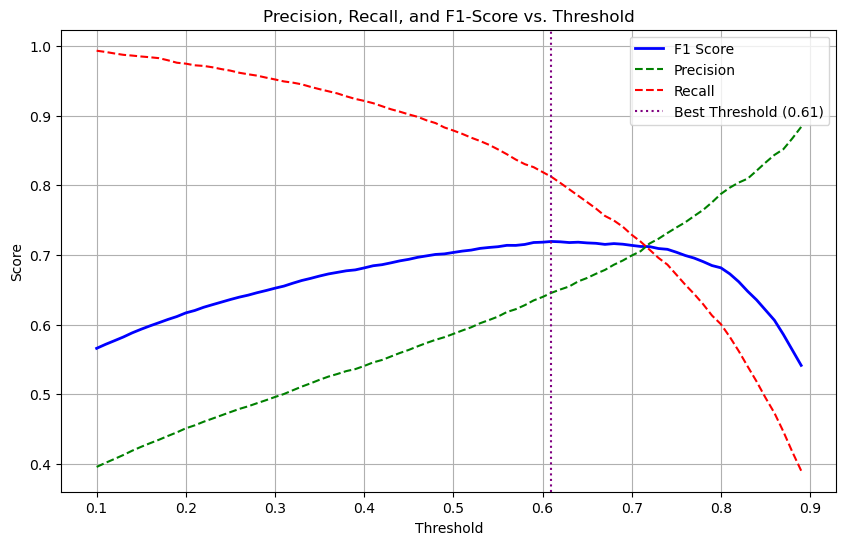

In [19]:
# Plotting the metrics vs. thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue', lw=2)
plt.plot(thresholds, precision_scores, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recall_scores, label='Recall', color='red', linestyle='--')

# Mark the best threshold
plt.axvline(x=best_threshold, color='purple', linestyle=':', label=f'Best Threshold ({best_threshold:.2f})')

plt.title('Precision, Recall, and F1-Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
y_pred_final = (y_prob_xgb_best >= best_threshold).astype('int')

print("--- Evaluation with Default Threshold (0.5) ---")
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_best)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_best)}')

print("\n\n--- Evaluation with Tuned Threshold ---")
print(f"Applied threshold: {best_threshold:.2f}")
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_final)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_final)}')

--- Evaluation with Default Threshold (0.5) ---

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.88     15417
           1       0.59      0.88      0.70      4583

    accuracy                           0.83     20000
   macro avg       0.77      0.85      0.79     20000
weighted avg       0.87      0.83      0.84     20000

Confusion Matrix:
 [[12581  2836]
 [  556  4027]]


--- Evaluation with Tuned Threshold ---
Applied threshold: 0.61

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     15417
           1       0.65      0.81      0.72      4583

    accuracy                           0.85     20000
   macro avg       0.79      0.84      0.81     20000
weighted avg       0.87      0.85      0.86     20000

Confusion Matrix:
 [[13375  2042]
 [  861  3722]]


In [21]:
# Create a pipeline for best XGBoost (Recall, modified threshold)
pipe_xgb_best = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('best_xgb', XGBClassifier(eval_metric='aucpr', scale_pos_weight=scale_pos_weight, **best_params_xgb_recall))
])

pipe_xgb_best.fit(X_train, y_train)

y_prob_xgb_best = pipe_xgb_best.predict_proba(X_test)[:,1]
y_pred_xgb_best = (y_prob_xgb_best >= best_threshold).astype(int)

precision_xgb_best, recall_xgb_best, _ = precision_recall_curve(y_test, y_prob_xgb_best)

print(f'XGBoost Random Search Model (Recall focus, {best_threshold:.2f} threshold)')
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb_best)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob_xgb_best)}')
print(f'PR AUC: {auc(recall_xgb_best, precision_xgb_best)}')
print(f'Training Accuracy: {accuracy_score(y_train, pipe_xgb_best.predict(X_train))}')
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_xgb_best)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_xgb_best)}')

XGBoost Random Search Model (Recall focus, 0.61 threshold)
Accuracy: 0.85485
ROC AUC: 0.9288525871456469
PR AUC: 0.8030101887907475
Training Accuracy: 0.8359375

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     15417
           1       0.65      0.81      0.72      4583

    accuracy                           0.85     20000
   macro avg       0.79      0.84      0.81     20000
weighted avg       0.87      0.85      0.86     20000

Confusion Matrix:
 [[13375  2042]
 [  861  3722]]


*In this model, a compromise was made. The number of false positives (false alarm) dropped from 2836 to 2042. While the number of false negatives (uncatched employees who resigned) increased from 556 to 861. A lower false alarm count means that HR will not waste as much resources checking on false positives, at the cost of increased uncatched employees who will resign. This also provides the best F1 score, the balance between precision and recall. This model's testing and training accuracy are similar, showing no signs of overfitting and can generalize new and unseen data well.*

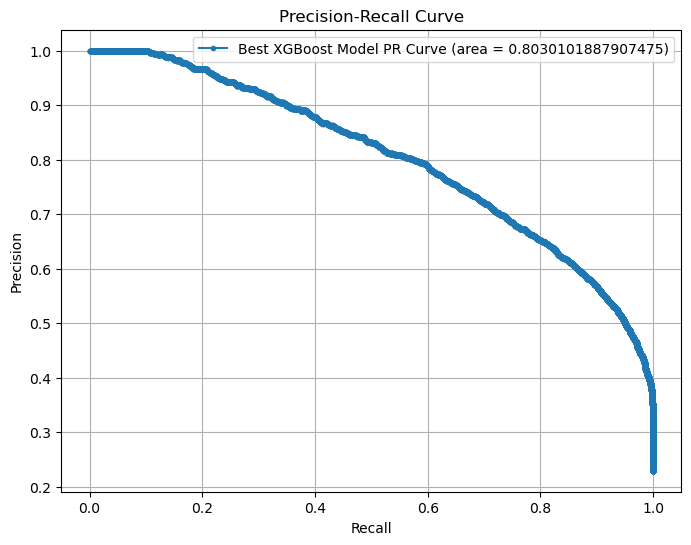

In [22]:
# Plot the Precision-Recall curve of the best XGBoost model
precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb_best)
pr_auc_best = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Best XGBoost Model PR Curve (area = {pr_auc_best})', marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()
plt.show()